**Optimization in Deep Learning**

Goal of this tutorial: Visualize the effect of different optimizers used in deep learning

- Gradient descent
- Momentum
- ADAM (see https://arxiv.org/abs/1412.6980 for the full details).

h/t: [CMU 11-785](http://deeplearning.cs.cmu.edu/S21/document/recitation/Recitation3_IDL_S21.ipynb) and this fantastic [Distill.pub](https://distill.pub/2017/momentum/) article.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

In [2]:
init = torch.tensor([-5.0,7.5])

class QuadFunc:
    def __init__(self,a,b,c,d,e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
    
    def getParams(self,x,y):
        if y is None:
            y = x[1]
            x = x[0]       
        return x, y
    
    def __call__(self,x,y=None):
        x,y = self.getParams(x,y)
        return 0.5*(self.a*x**2 + self.b*y**2 + 2*self.c*x*y) + self.d*x + self.e*y
    
    def grad(self,x,y=None):
        x,y = self.getParams(x,y)
        return torch.tensor([self.a*x+self.c*y+self.d,self.b*y+self.c*x+self.e])
    
    def hess(self,x,y=None):
        x,y = self.getParams(x,y)
        return torch.tensor([[self.a,self.c],[self.c,self.b]])

class GradientDescent:
    
    def __init__(self,lr=1,b1=0.9,b2=0.999):
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param
        self.b2 = b2 # grad^2 aggregation param
        
        self.v = 0 # grad aggregation
        self.w = 0 # grad^2 aggregation
        self.t = 0
            
        self.eps = 1.0e-9
        
    def __call__(self,grad,hess):
        
        self.t += 1
        
        # aggregation
        self.v = self.b1*(self.v) + (1-self.b1)*grad
        self.w = self.b2*(self.w) + (1-self.b2)*grad**2
        
        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1
        
        return -self.lr*vcorr/( wcorr**0.5 + self.eps )
        
  
        

class NAG:
    
    def __init__(self,lr=1,gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.m = 0
        
    def __call__(self,grad,hess):
        # Grad and Hess passed here are based on future location based on prior momentum
        
        self.m = self.gamma * self.m + grad
        return -self.lr*self.m

class NAG2:
    
    def __init__(self,lr=1,gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.m = 0
        
    def __call__(self,grad,hess):
        # Dozat's implementation
        
        self.m = self.gamma * self.m + grad
        return -self.lr*(grad+self.gamma*self.m)
    
def runOptim(init,optim,func,steps,nag=False):
    
    curpos = init
    path = [curpos]
    val = [func(curpos)]
    
    for _ in range(steps):
        
        if nag:
            grad = func.grad(curpos-optim.lr*optim.gamma*optim.m)
            hess = func.hess(curpos-optim.lr*optim.gamma*optim.m)            
        else:
            grad = func.grad(curpos)
            hess = func.hess(curpos)
            
        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)
        val.append(func(curpos))
    
    return path, val

def showPath(func,init,paths,labels,colors,title):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)
    
    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)
    
    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,cmap=cm.gray)
    fig.colorbar(cp)
    
    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')
    
    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')
    
    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)
    
    # Add title
    ax.set_title(title)

We will try to visualize running gradient descent (and its variants) on a simple quadratic function in two variables:
$$f(x,y) = ax^2 + by^2 + cxy + dx + ey $$

By setting the constants differently, the above function represents all conic surfaces -- paraboloids, hyperboloids, ellipsoids, etc. Let's see how to optimize these functions.

# Regular gradient descent

Let's start with a simple parabolic function: $f(x,y) = x^2 + y^2$. Here, the function is convex, the "valley" has a unique global minimum, and optimization is straightforward.

C:\Users\hawkp\miniconda3\envs\pytorch\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


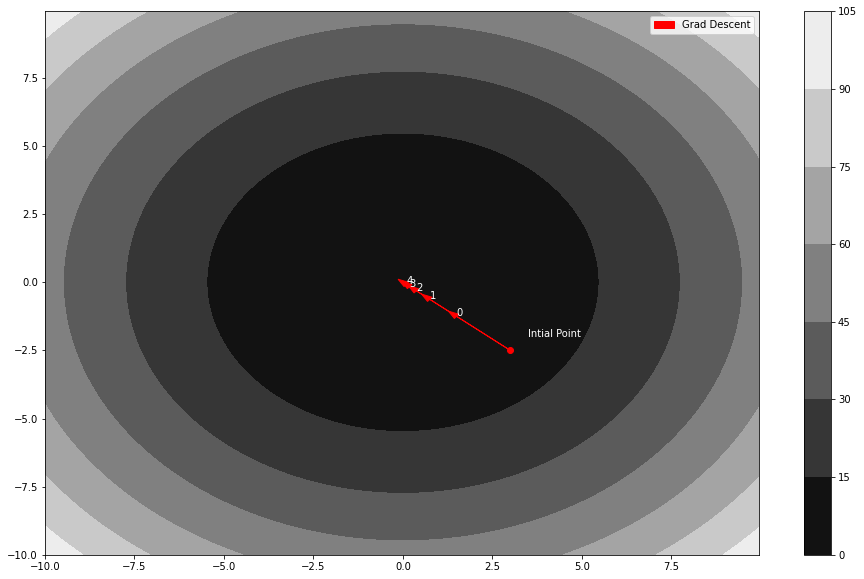

In [3]:
simple = QuadFunc(1, 1, 0, 0, 0)
init = torch.tensor([3.0,-2.5])
regGD = GradientDescent(0.5,0,0)
steps = 5
path, _ = runOptim(init,regGD,simple,steps)
showPath(simple,init,[path],['Grad Descent'],['r'],'')

Unfortunately, in deep learning we tend to not optimize such simple convex functions. 

Let's go back to the convex case (where everything is supposed to work). Choose a parabolic function where the level set contours are skewed ellipses: $$f(x,y) = x^2 + y^2 - 0.8 xy + x + y.$$ 
In such cases, gradient descent (which just follows the locally steepest direction) tends to oscillate quite a bit.

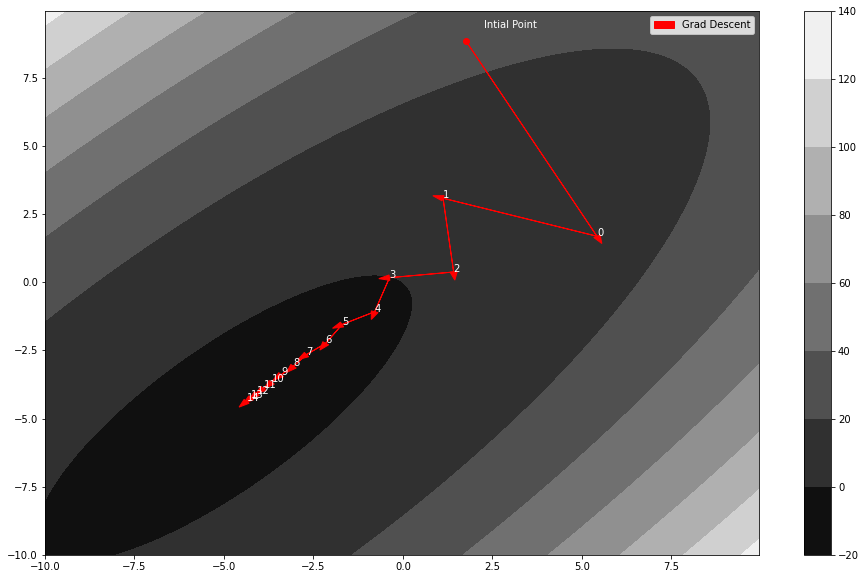

In [4]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 15
regGD = GradientDescent(1.2,0,0)
path, _ = runOptim(init,regGD,ell,steps)
showPath(ell,init,[path],['Grad Descent'],['r'],'')

# Momentum

Momentum is a way to simulate the effects of [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) without looking at second order information. It adds a "damping" effect on the oscillations (so that the trajectories are typically smoother than standard GD). Let's see its effects in the ellipse example.

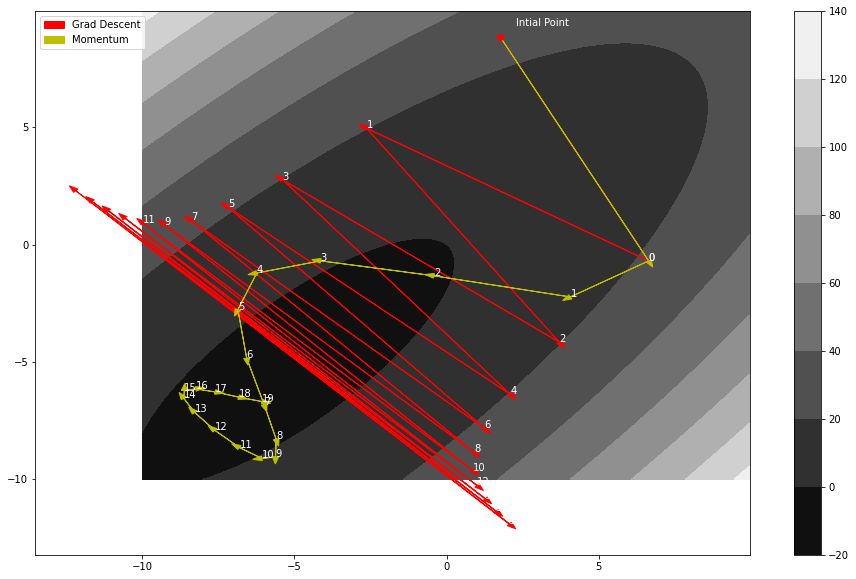

In [5]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 20
lr = 1.6
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
path1, _ = runOptim(init,regGD,ell,steps)
path2, _ = runOptim(init,momGD,ell,steps)
showPath(ell,init,[path1,path2],['Grad Descent','Momentum'],['r','y'],'')

# ADAM

As we can see, momentum speeds up gradient descent but there's still the issue of tuning the learning rate property.

ADAM takes care of this by automatically tuning the learning rate ("adaptive scheduling"). 

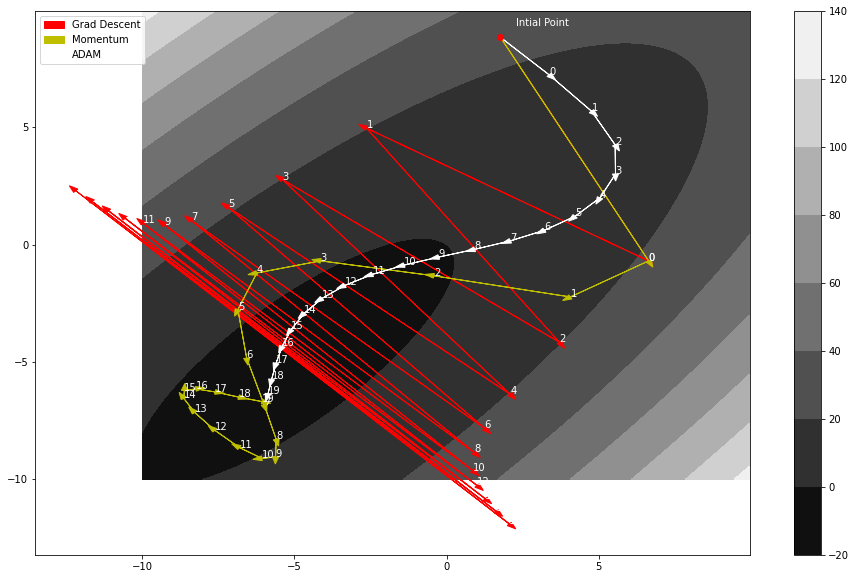

In [6]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 20
lr = 1.6
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1, _ = runOptim(init,regGD,ell,steps)
path2, _ = runOptim(init,momGD,ell,steps)
path3, _ = runOptim(init,adamGD,ell,steps)
showPath(ell,init,[path1,path2,path3],['Grad Descent','Momentum','ADAM'],['r','y','w'],'')

That's it! Feel free to play around with various parameters -- different optimizers, different learning rates, damping factors, etc. 

Onto the big question: which optimizer should be used? 

Unfortunately there is no clear answer. The choice of "best" optimizer seems to be model-dependent. A general couple of thumb rules:
* For vision applications involving ResNets, SGD + momentum seems to be sufficient.
* for NLP applications and transformer architectures, ADAM seems to work really well.

In practice, it may be useful to play around with different optimizers and perform some basic hyperparameter tuning depending on your specific problem.

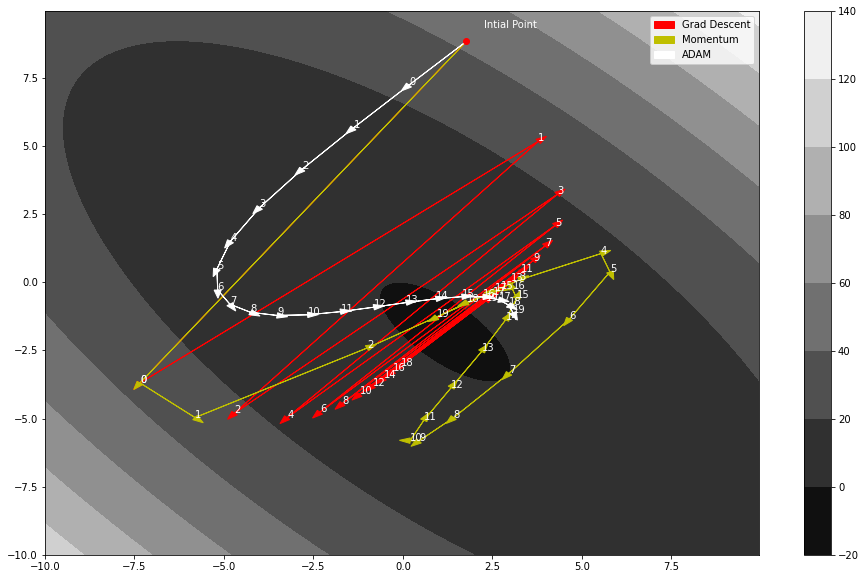

In [7]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,0.7*a,0.1*a,a)
steps = 20
lr = 1.6
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1, _ = runOptim(init,regGD,ell,steps)
path2, _ = runOptim(init,momGD,ell,steps)
path3, _ = runOptim(init,adamGD,ell,steps)
showPath(ell,init,[path1,path2,path3],['Grad Descent','Momentum','ADAM'],['r','y','w'],'')

Finding efficient algorithms of optimization is an active research area (i.e. *hot*) in deep learning. For example, there has been recently a new optimizer proposed, [Madgrad](https://arxiv.org/abs/2101.11075), which seems to perform better than the Adam optimizer across various datasets.